In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
from pathlib import Path

In [2]:
model_name_it = "Efficient_net_B0_it.h5"

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [5]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [6]:
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [7]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [8]:
# gen_params ={"rotation_range":20,\
#               "width_shift_range":0.1,\
#               "height_shift_range":0.1, \
#               "horizontal_flip":False,\
#               "vertical_flip":False}
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":False,\
              "vertical_flip":False}

Train and validation generators

In [9]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = \
                               tf.keras.applications.efficientnet.preprocess_input)

In [10]:
bs = 16 # batch size

In [11]:
path = Path("D:/Mestrado/ENEL645/Assigment_3/cards_dataset/whole_dataset/term-project/dataset")

In [12]:
img_height = 320
img_width = 320

In [13]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "joker,"
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]
              

In [14]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    shuffle=True,
    seed=42,
    classes = classes_names) # set as training data

Found 1105 images belonging to 52 classes.


In [15]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    shuffle=True,
    seed=42,
    classes = classes_names) # set as validation data

Found 252 images belonging to 52 classes.


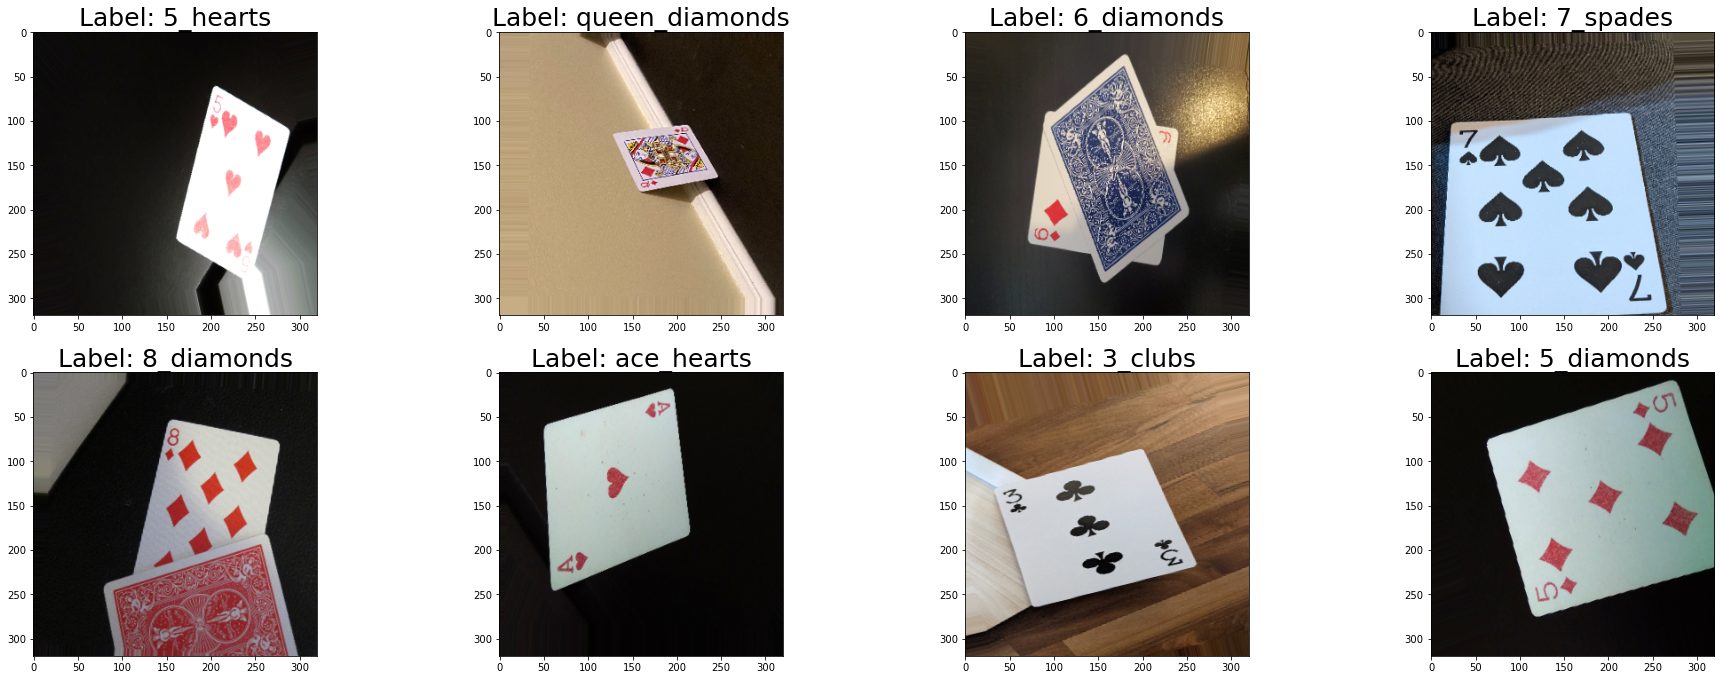

In [16]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)
for ii in range(int(bs/2)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [17]:
# Defining the model

In [18]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', 
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [20]:
base_model.trainable = True

In [21]:
x1 = base_model(base_model.input, training = True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(classes_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

In [22]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 10, 10, 1280)     4049571   
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 52)                6656052   
                                                                 
Total params: 10,705,623
Trainable params: 10,663,600
Non-trainable params: 42,023
_________________________________________________________________
None


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it])

Epoch 1/1000
70/70 [==============================] - 30s 404ms/step - loss: 0.0956 - accuracy: 0.9701 - val_loss: 3.6149 - val_accuracy: 0.2897
Epoch 2/1000
70/70 [==============================] - 29s 386ms/step - loss: 0.0693 - accuracy: 0.9801 - val_loss: 3.8634 - val_accuracy: 0.2937
Epoch 3/1000
70/70 [==============================] - 29s 386ms/step - loss: 0.0839 - accuracy: 0.9810 - val_loss: 4.0185 - val_accuracy: 0.2222
Epoch 4/1000
70/70 [==============================] - 29s 393ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 3.6187 - val_accuracy: 0.3214
Epoch 5/1000
70/70 [==============================] - 31s 390ms/step - loss: 0.1370 - accuracy: 0.9620 - val_loss: 4.1667 - val_accuracy: 0.2500
Epoch 6/1000
70/70 [==============================] - 29s 389ms/step - loss: 0.1472 - accuracy: 0.9538 - val_loss: 3.7724 - val_accuracy: 0.2619
Epoch 7/1000
70/70 [==============================] - 31s 389ms/step - loss: 0.0716 - accuracy: 0.9701 - val_loss: 3.9277 - val_ac

70/70 [==============================] - 32s 421ms/step - loss: 0.0292 - accuracy: 0.9919 - val_loss: 4.8806 - val_accuracy: 0.3056
Epoch 58/1000
70/70 [==============================] - 30s 399ms/step - loss: 0.0777 - accuracy: 0.9801 - val_loss: 4.7501 - val_accuracy: 0.3095
Epoch 59/1000
70/70 [==============================] - 30s 399ms/step - loss: 0.0423 - accuracy: 0.9919 - val_loss: 4.6506 - val_accuracy: 0.3333
Epoch 60/1000
70/70 [==============================] - 30s 398ms/step - loss: 0.0225 - accuracy: 0.9910 - val_loss: 4.8309 - val_accuracy: 0.3492
Epoch 61/1000
70/70 [==============================] - 32s 429ms/step - loss: 0.0295 - accuracy: 0.9928 - val_loss: 4.8108 - val_accuracy: 0.3532
Epoch 62/1000
70/70 [==============================] - 32s 423ms/step - loss: 0.0540 - accuracy: 0.9873 - val_loss: 5.0953 - val_accuracy: 0.2976
Epoch 63/1000
70/70 [==============================] - 32s 429ms/step - loss: 0.0759 - accuracy: 0.9855 - val_loss: 5.0720 - val_accuracy: